<a href="https://colab.research.google.com/github/ReutDanino/Semantic-segmentation-mini-project/blob/main/Final_project_with_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install

In [1]:
!pip install keras_unet

In [2]:
!pip install Augmentor

##Connection to the drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Imports


In [4]:
# Import necessary libraries
import numpy as np
import glob
from PIL import Image
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras_unet.utils import plot_imgs
from keras_unet.models import custom_unet
from keras_unet.metrics import iou, iou_thresholded
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


##Paths

In [5]:
# Define paths for images and masks for train
image_paths = glob.glob("/content/drive/MyDrive/תמונות מעובדות/train/CXR_png/*.png")
mask_paths = glob.glob("/content/drive/MyDrive/תמונות מעובדות/train/masks/*.png")

# Define paths for images and masks for validation
image_val_paths = glob.glob("/content/drive/MyDrive/תמונות מעובדות/validation/CXR_png/*.png")
mask_val_paths = glob.glob("/content/drive/MyDrive/תמונות מעובדות/validation/masks/*.png")

# Define paths for images and masks for test
image_test_paths = glob.glob("/content/drive/MyDrive/תמונות מעובדות/test מחולק/CXR_png/*.png")
mask_test_paths = glob.glob("/content/drive/MyDrive/תמונות מעובדות/test מחולק/masks/*.png")

# Example image path for testing
image_path = "/content/drive/MyDrive/תמונות מעובדות/test מחולק/CXR_png/CHNCXR_0540_1.png"

##Data preparation

In [6]:
# Ensuring that images and their corresponding masks are aligned
image_paths.sort()
mask_paths.sort()


# Select a subset of images and masks
image_paths = image_paths[0:300]
mask_paths = mask_paths[0:300]


# Set image dimensions
num_images = len(image_paths)
width, height = 400,400
imgs_list = []
masks_list = []


# Load and preprocess images and masks
for image, mask in zip(image_paths, mask_paths):
    imgs_list.append(np.array(Image.open(image).convert("RGB").resize((width, height))))
    mask_img = Image.open(mask).resize((width, height))
    masks_list.append(np.array(mask_img))


imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)


# Convert masks to binary (black and white)
masks_np = np.where(masks_np > 0, 255, 0)


# Normalize images and masks
x_train = np.asarray(imgs_np, dtype=np.float32)/255
y_train = np.asarray(masks_np, dtype=np.float32)/255


# Reshape masks for training
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1)

In [7]:
print(np.unique(imgs_np), np.unique(masks_np))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [8]:
print(x_train.shape, y_train.shape)

(300, 400, 400, 3) (300, 400, 400, 1)


# Plot a few images and their corresponding masks from the train

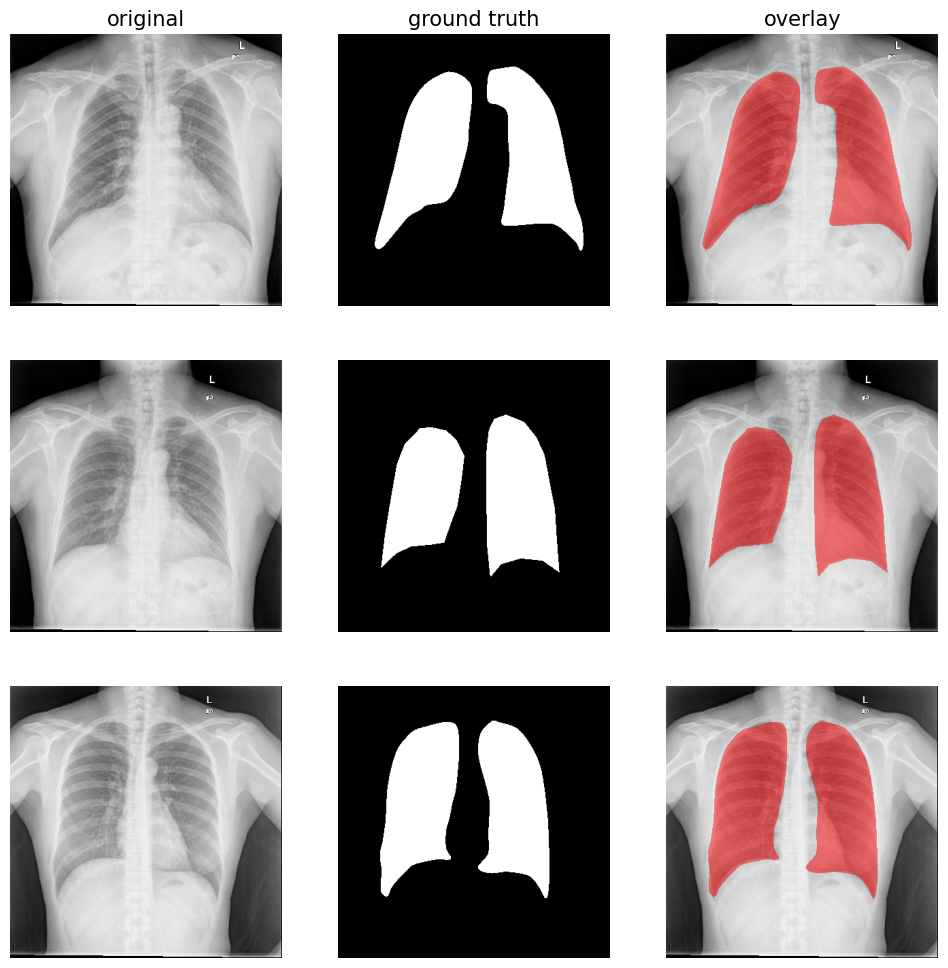

In [9]:
plot_imgs(org_imgs=imgs_np, mask_imgs=masks_np, nm_img_to_plot=3, figsize=4)

# Repeat the process for validation data


In [10]:
# Sort to ensure corresponding images and masks
image_val_paths.sort()
mask_val_paths.sort()


# Select a subset of images and masks
image_val_paths = image_val_paths[0:30]
mask_val_paths = mask_val_paths[0:30]

num_images_val = len(image_val_paths)
image_val_list = []
mask_val_list = []


# Load and preprocess images and masks
for img_val, mask_val in zip(image_val_paths, mask_val_paths):
    image_val_list.append(np.array(Image.open(img_val).convert("RGB").resize((width, height))))
    im_val = Image.open(mask_val).resize((width, height))
    mask_val_list.append(np.array(im_val))


imgs_np_val = np.asarray(image_val_list)
masks_np_val = np.asarray(mask_val_list)


# Convert mask images to binary (black and white)
masks_np_val = np.where(masks_np_val > 0, 255, 0)


# Normalize images for validation
x_val = np.asarray(imgs_np_val, dtype=np.float32)/255
y_val = np.asarray(masks_np_val, dtype=np.float32)/255


# Reshape masks to add channel dimension
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], y_val.shape[2], 1)

In [11]:
print(np.unique(imgs_np_val), np.unique(masks_np_val))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [12]:
print(x_val.shape, y_val.shape)

(30, 400, 400, 3) (30, 400, 400, 1)


# Plot a few images and their corresponding masks from the validation

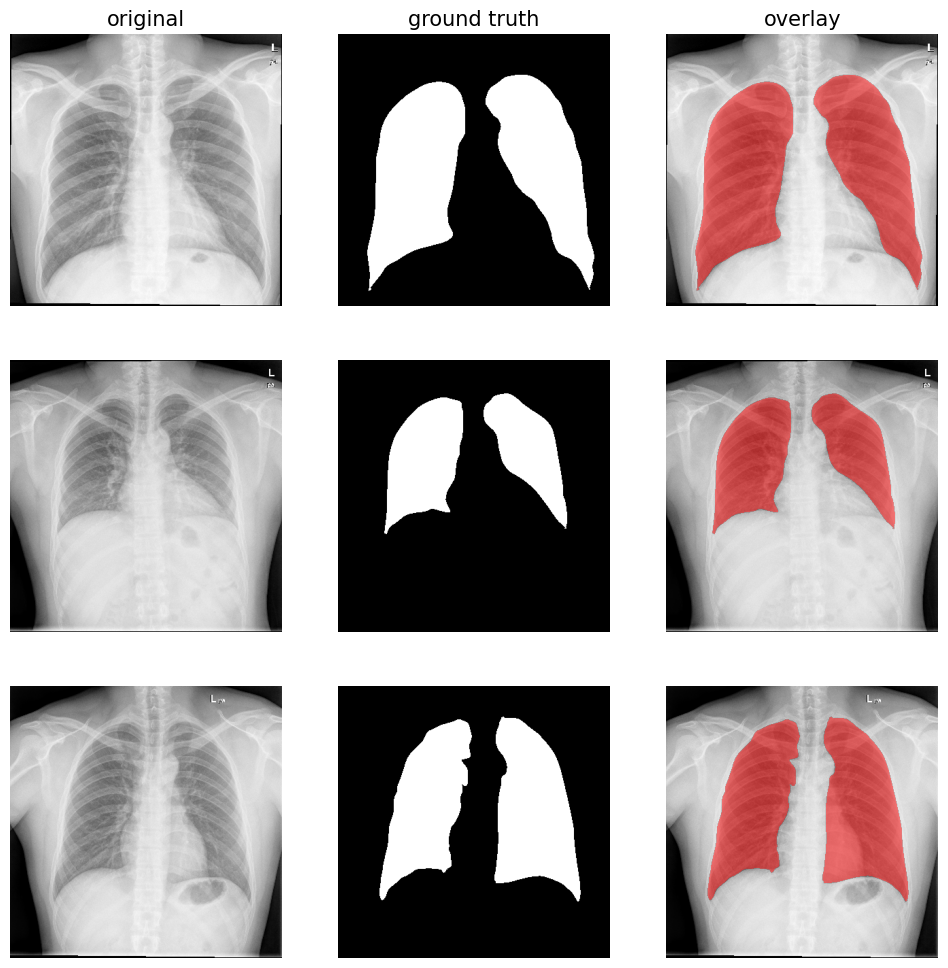

In [13]:
plot_imgs(org_imgs=imgs_np_val, mask_imgs=masks_np_val, nm_img_to_plot=3, figsize=4)

In [14]:
# Printing the shapes of training and validation datasets to verify their dimensions
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (300, 400, 400, 3)
y_train:  (300, 400, 400, 1)
x_val:  (30, 400, 400, 3)
y_val:  (30, 400, 400, 1)


#UNET network definition


In [21]:
# Define augmentation for training images and masks
def aug():
    data_gen_args = dict(
        width_shift_range=0.05,  # Horizontal shift up to 5% of image width
        height_shift_range=0.05, # Vertical shift up to 5% of image height
        zoom_range=0.1,          # Zoom in/out up to 10%
        horizontal_flip=True,    # Horizontal flip
        fill_mode='nearest'      # Fill missing pixels based on nearest ones
    )

    # Create ImageDataGenerator with the same parameters for images and masks
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)



    # Create image and mask generators using the same random seed to ensure synchronization
    rand = random.randint(1, 100)
    print(rand)
    batch_size = 5
    image_generator = image_datagen.flow(x_train, batch_size=batch_size, seed=rand)
    mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=rand)

    # Combine the image and mask generators
    combined_generator = create_combined_generator(image_generator, mask_generator)
    return combined_generator

# Function to display samples from the combined generator
def display_generator_samples(combined_gen, num_samples=1):
    for _ in range(num_samples):
        img_batch, mask_batch = next(combined_gen)

        for img, mask in zip(img_batch, mask_batch):
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            if img.max() <= 1:
                img = (img * 255).astype('uint8')
            ax[0].imshow(img)      # Display image
            ax[0].set_title('Image')
            ax[1].imshow(mask.squeeze(), cmap='gray')  # Display mask
            ax[1].set_title('Mask')
            plt.show()

# Function to combine image and mask generators to ensure they yield corresponding pairs
def create_combined_generator(image_gen, mask_gen):
    while True:
        img_batch = next(image_gen)
        mask_batch = next(mask_gen)
        yield img_batch, mask_batch


# Combined generator for training
train_gen = aug()

54


In [22]:
# Define generators for validation without augmentation
val_image_datagen = ImageDataGenerator()
val_mask_datagen = ImageDataGenerator()
batch_size = 5
seed=1
val_image_generator = val_image_datagen.flow(x_val, batch_size=batch_size, seed=seed)
val_mask_generator = val_mask_datagen.flow(y_val, batch_size=batch_size, seed=seed)
val_gen = create_combined_generator(val_image_generator, val_mask_generator)

## Display samples from the training and validation generators


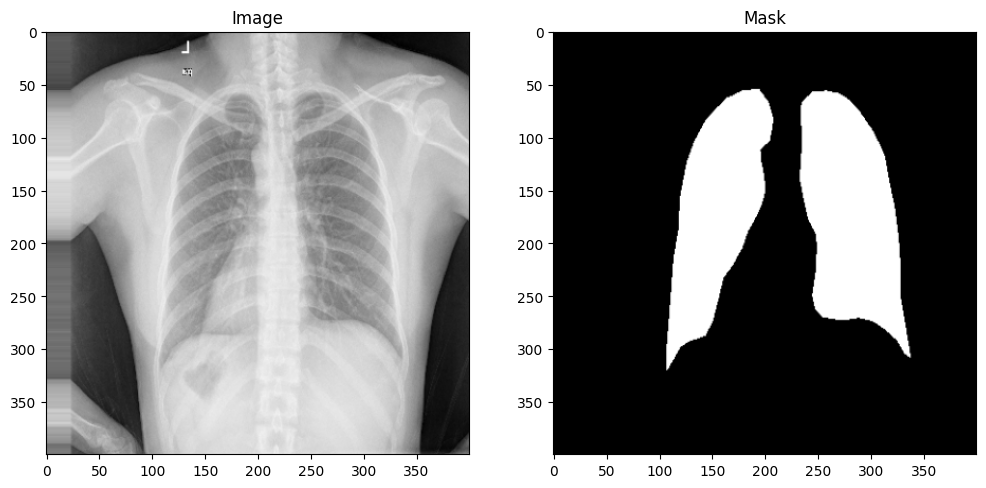

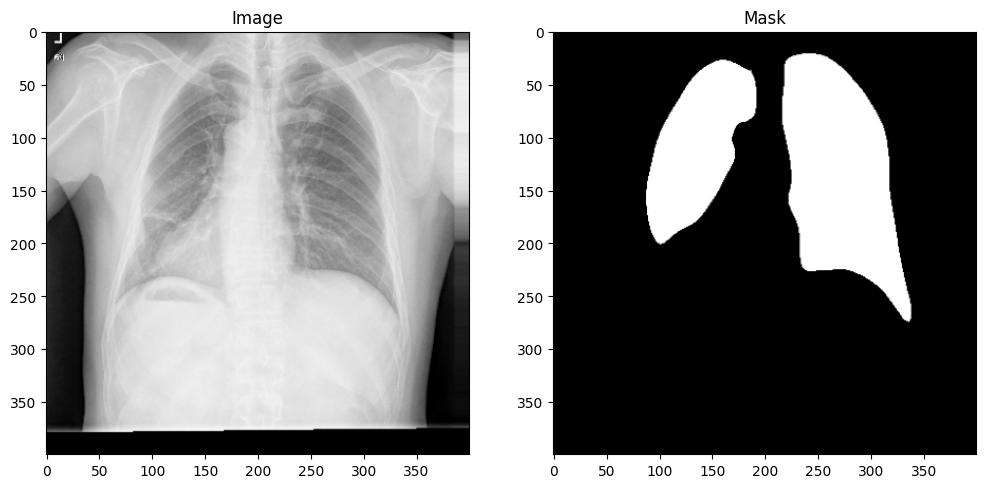

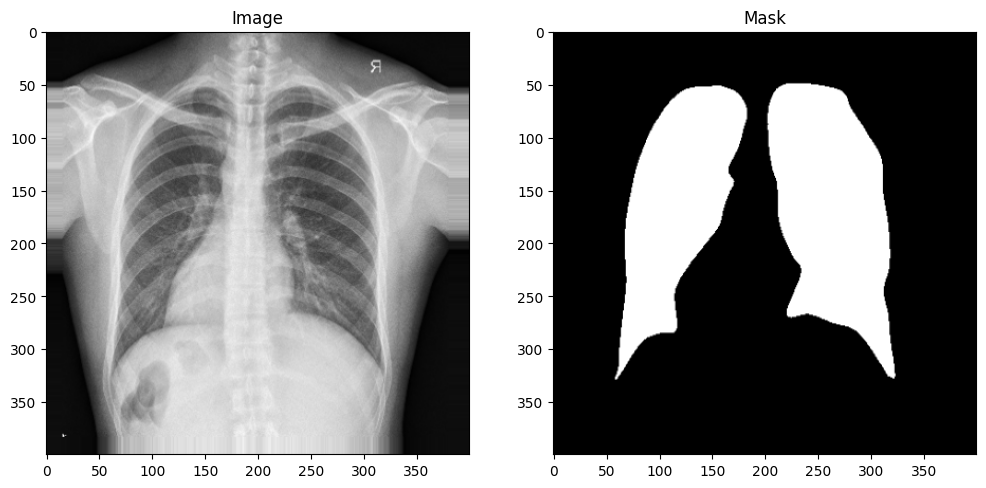

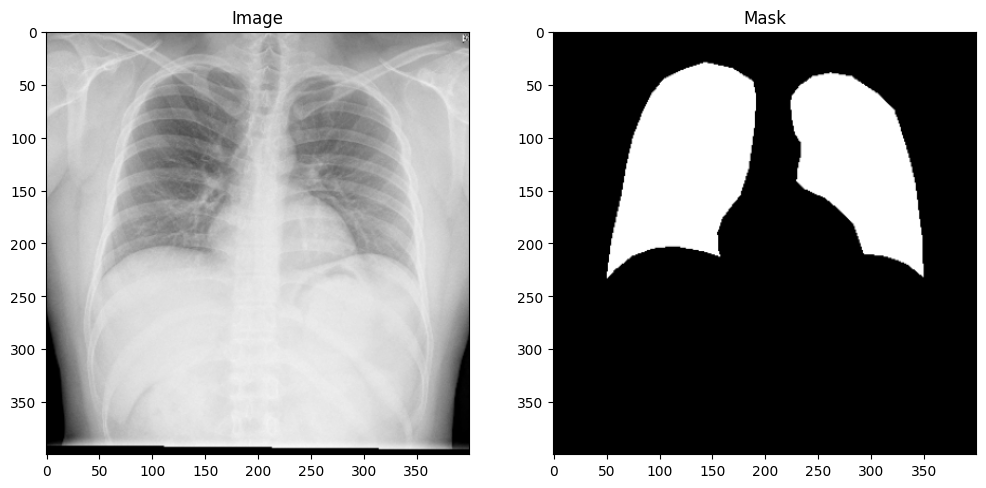

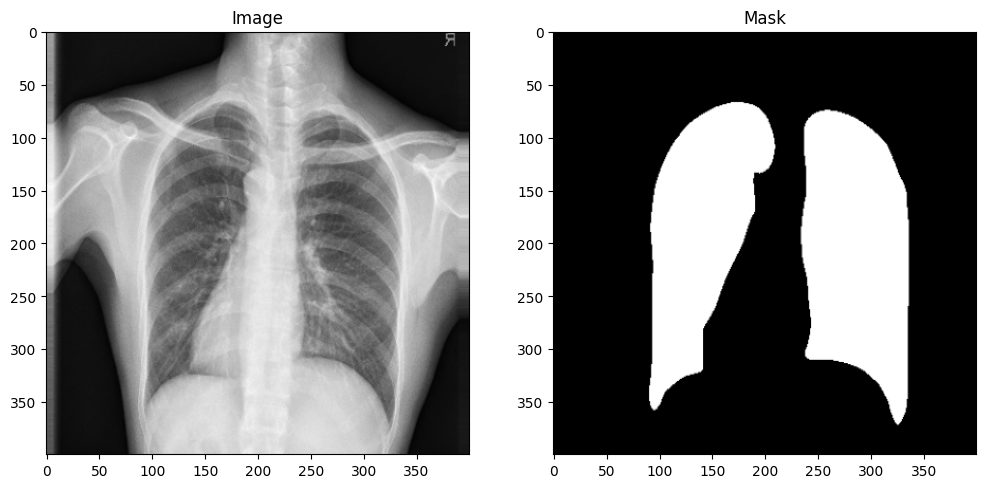

In [23]:
# train
display_generator_samples(train_gen)

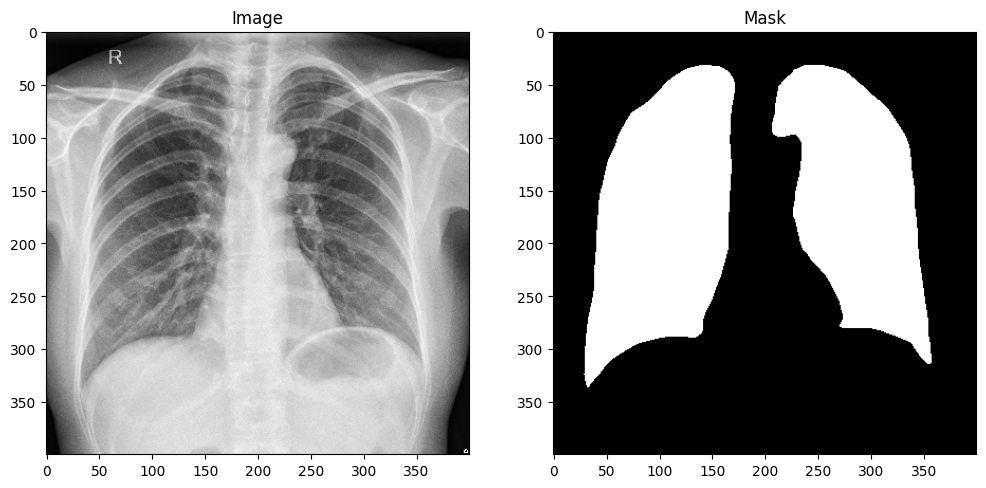

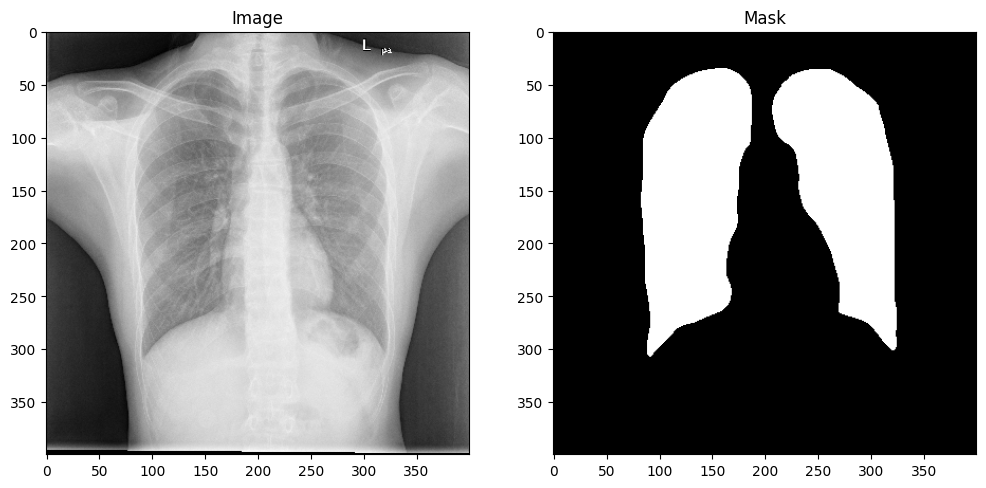

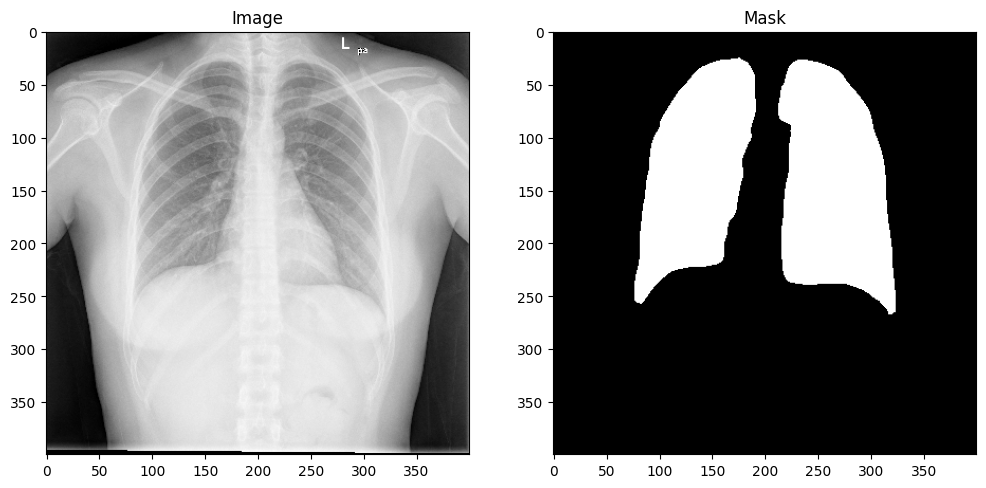

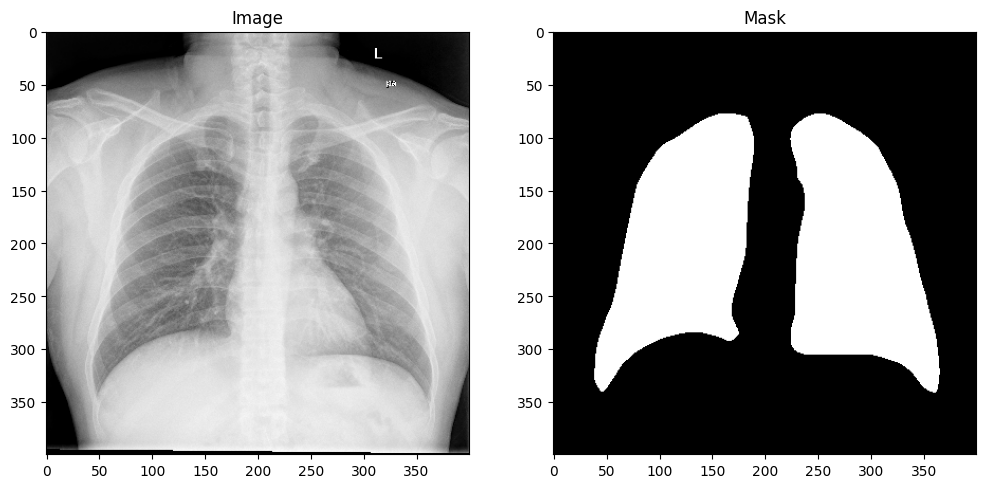

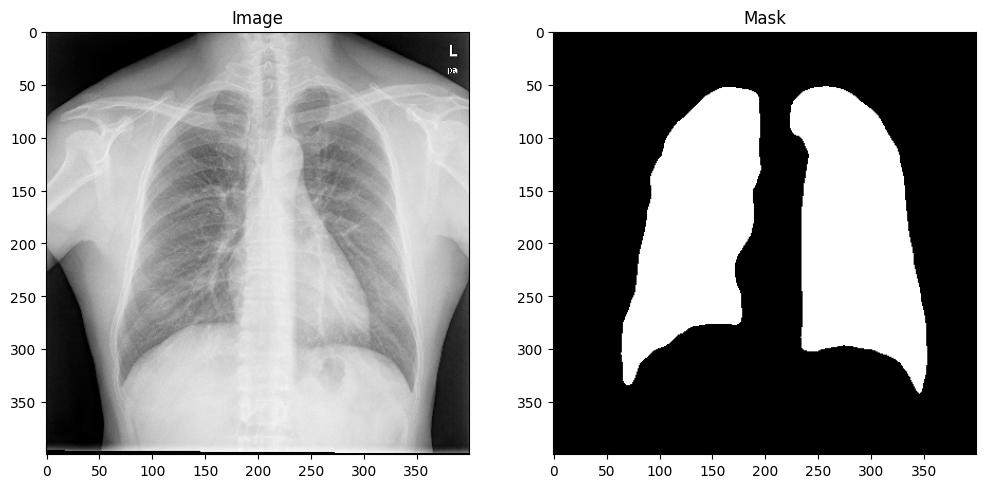

In [24]:
# validation
display_generator_samples(val_gen)

In [ ]:
# Get the shape of the input images from the training data
input_shape = x_train[0].shape

# Define the custom U-Net model with specified parameters
model = custom_unet(
    input_shape,                  # Shape of the input images
    use_batch_norm=False,         # Whether to use batch normalization
    num_classes=1,                # Number of output classes (1 for binary segmentation)
    filters=50,                   # Number of filters in the first convolutional layer
    dropout=0.1,                  # Dropout rate for regularization
    output_activation='sigmoid'   # Activation function for the output layer
)

# Compile the model with specified parameters
model.compile(
    optimizer=Adam(learning_rate=1e-3),  # Define the optimizer with a learning rate of 1e-3
    loss='binary_crossentropy',          # Use binary cross-entropy as the loss function
    metrics=[iou, iou_thresholded]       # Define the metrics to evaluate the model (IoU and thresholded IoU)
)

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor the validation loss
    patience=6,                # Stop training if the validation loss doesn't improve for 10 consecutive epochs
    restore_best_weights=True   # Restore the model weights from the epoch with the best validation loss
    )

# Calculate the number of steps per epoch for training and validation
steps_per_epoch = max(1, len(x_train) // batch_size)
validation_steps = max(1, len(x_val) // batch_size)

In [ ]:
combined_history = {
    'loss': [],
    'iou': [],
    'iou_thresholded': [],
    'val_loss': [],
    'val_iou': [],
    'val_iou_thresholded': []
}

In [ ]:
# Train the model with augmented data
for i in range(1,9):
    train_gen=aug()                     # Generate a new augmented training generator
    history=model.fit(                  # Fit the model
    train_gen,                          # Training generator
    steps_per_epoch=steps_per_epoch,    # Number of steps per epoch
    epochs=5,                           # Number of epochs per round
    validation_data=val_gen,            # Validation generator
    validation_steps=validation_steps,  # Number of validation steps
    callbacks=[early_stopping]          # Early stopping callback
    )
    # Append history to combined_history
    for key in combined_history.keys():
        combined_history[key].extend(history.history[key])
    flag = 0

    if i>=2:
      last_10_val_loss = combined_history['val_loss'][-10:]
      for j in range(1, len(last_10_val_loss)):
        current_val_loss = last_10_val_loss[j]
        previous_val_loss = last_10_val_loss[j-1]
        if previous_val_loss-current_val_loss>0.01:
          flag=1
        if flag:
          break

    if not flag and i>=2:
      break



1
Epoch 1/5
60/60 [==============================] - 44s 725ms/step - loss: 0.1281 - iou: 0.7473 - iou_thresholded: 0.8243 - val_loss: 0.1766 - val_iou: 0.7034 - val_iou_thresholded: 0.7572
Epoch 2/5
60/60 [==============================] - 43s 712ms/step - loss: 0.1155 - iou: 0.7656 - iou_thresholded: 0.8396 - val_loss: 0.1202 - val_iou: 0.7895 - val_iou_thresholded: 0.8376
Epoch 3/5
60/60 [==============================] - 43s 712ms/step - loss: 0.1180 - iou: 0.7729 - iou_thresholded: 0.8410 - val_loss: 0.1127 - val_iou: 0.7804 - val_iou_thresholded: 0.8433
Epoch 4/5
60/60 [==============================] - 43s 712ms/step - loss: 0.0860 - iou: 0.8234 - iou_thresholded: 0.8759 - val_loss: 0.0986 - val_iou: 0.8103 - val_iou_thresholded: 0.8704
Epoch 5/5
60/60 [==============================] - 43s 713ms/step - loss: 0.0831 - iou: 0.8311 - iou_thresholded: 0.8832 - val_loss: 0.0827 - val_iou: 0.8321 - val_iou_thresholded: 0.8802
97
Epoch 1/5
60/60 [==============================] - 43s 

In [ ]:
# Save the trained model
model.save('/content/drive/MyDrive/רעות לימודים/my_good_augmented_model.h5')

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 400, 400, 50)         1400      ['input_1[0][0]']             
                                                                                                  
 spatial_dropout2d (Spatial  (None, 400, 400, 50)         0         ['conv2d[0][0]']              
 Dropout2D)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 400, 400, 50)         22550     ['spatial_dropout2d[0][0]'

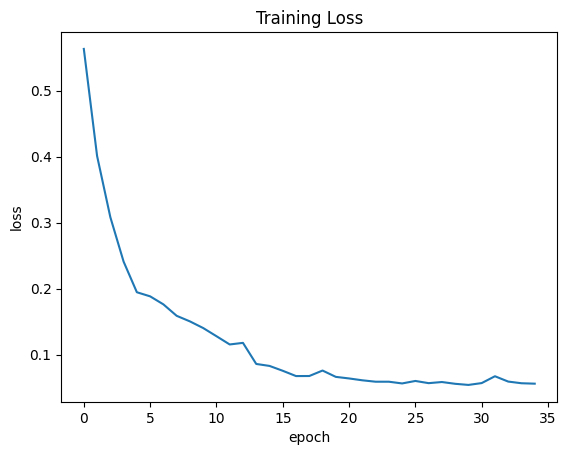

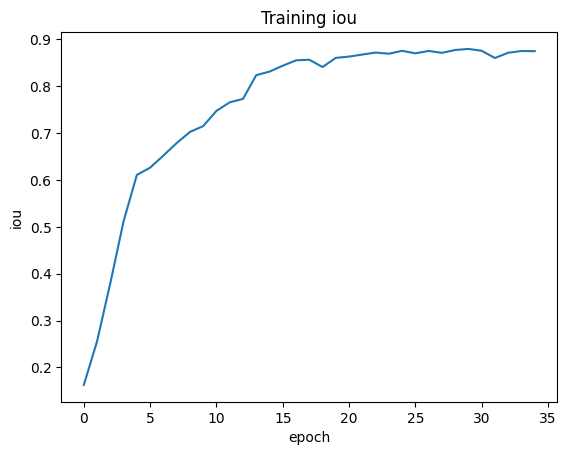

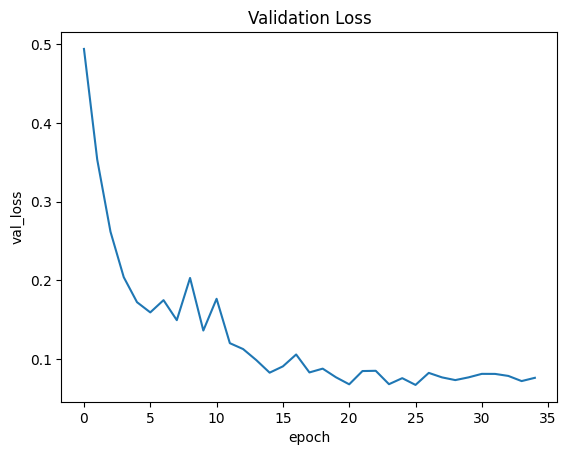

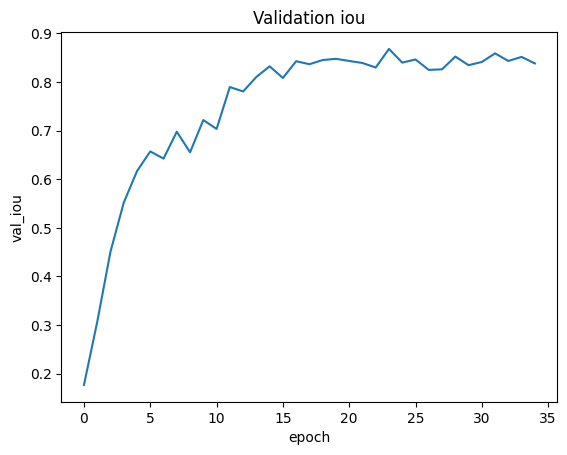

In [ ]:
# Plot training and validation loss
plt.plot(combined_history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(combined_history["iou"])
plt.title("Training iou")
plt.ylabel("iou")
plt.xlabel("epoch")
plt.show()

plt.plot(combined_history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(combined_history["val_iou"])
plt.title("Validation iou")
plt.ylabel("val_iou")
plt.xlabel("epoch")
plt.show()

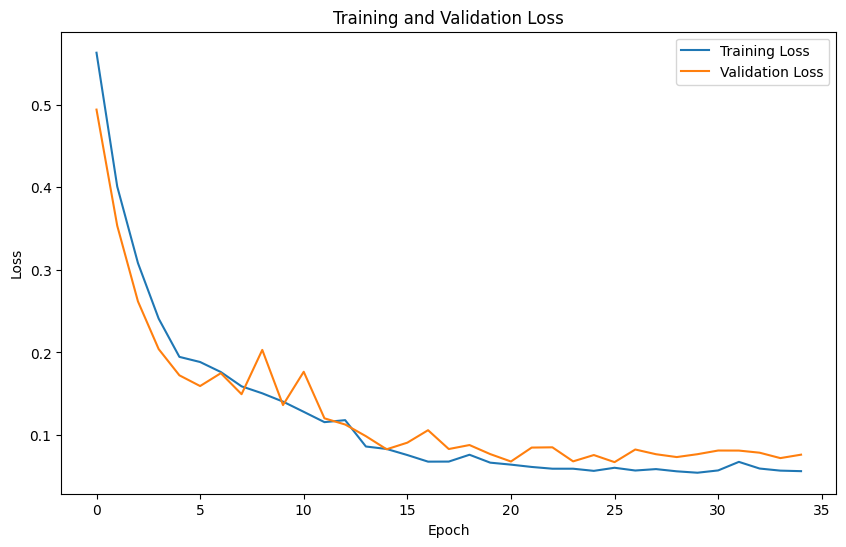

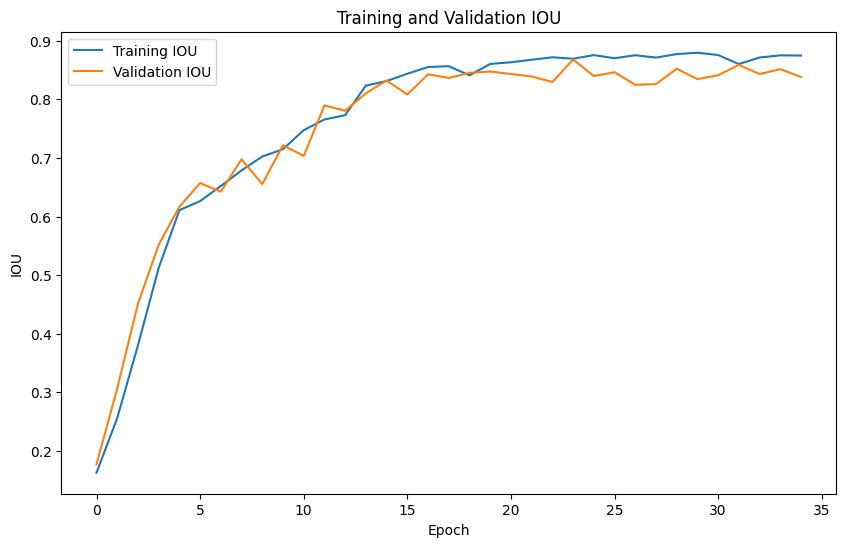

In [ ]:
# Combined plots for training and validation metrics
#loss
plt.figure(figsize=(10, 6))
plt.plot(combined_history["loss"], label="Training Loss")
plt.plot(combined_history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

#iou
plt.figure(figsize=(10, 6))
plt.plot(combined_history["iou"], label="Training IOU")
plt.plot(combined_history["val_iou"], label="Validation IOU")
plt.title("Training and Validation IOU")
plt.ylabel("IOU")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
# Sort the test image and mask
# Ensuring that images and their corresponding masks are aligned
image_test_paths.sort()
mask_test_paths.sort()

# Initialize lists to store the test images and masks
num_images_test = len(image_test_paths)
image_test_list = []
mask_test_list = []

# Load and preprocess the test images and masks
for image_test, mask_test in zip(image_test_paths, mask_test_paths):
    # Load and preprocess the test image
    image_test_list.append(np.array(Image.open(image_test).convert("RGB").resize((width, height))))
    # Load and preprocess the test mask
    im_test = Image.open(mask_test).resize((width, height))
    mask_test_list.append(np.array(im_test))


# Convert the lists to numpy arrays
imgs_np_test = np.asarray(image_test_list)
masks_np_test = np.asarray(mask_test_list)

# Binarize the test masks (convert to 0 and 255)
masks_np_test = np.where(masks_np_test > 0, 255, 0)


# Normalize the test images and masks
x_test = np.asarray(imgs_np_test, dtype=np.float32)/255
y_test = np.asarray(masks_np_test, dtype=np.float32)/255


# Reshape the test masks to add the channel dimension
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 1)

# Load the model
#model_path = '/content/drive/MyDrive/רעות לימודים/my_good_augmented_model.h5'
#model = load_model(model_path, custom_objects={'iou': iou, 'iou_thresholded': iou_thresholded})


# Evaluate the model on the test data
test_loss, test_iou, test_iou_thresholded = model.evaluate(x_test, y_test, verbose=0)

# Print the test evaluation results
print(f'Test Loss: {test_loss:.2f}')
print(f'Test IoU: {test_iou:.2f}')
print(f'Test IoU Thresholded: {test_iou_thresholded:.2f}')

Test Loss: 0.07
Test IoU: 0.87
Test IoU Thresholded: 0.92


1/1 [==============================] - 3s 3s/step
Input image shape: (400, 400, 3)
Input image values (min, max): (0.0, 1.0)
Predicted mask shape: (400, 400, 1)
Predicted mask values (min, max): (1.0283704e-18, 1.0)
Binary mask values (unique): [0 1]


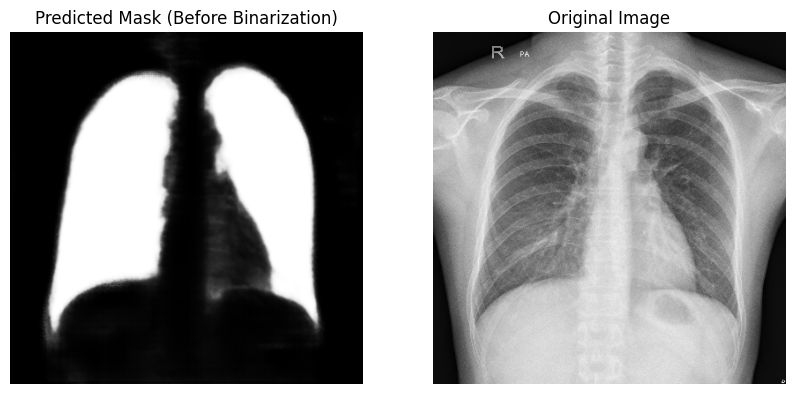

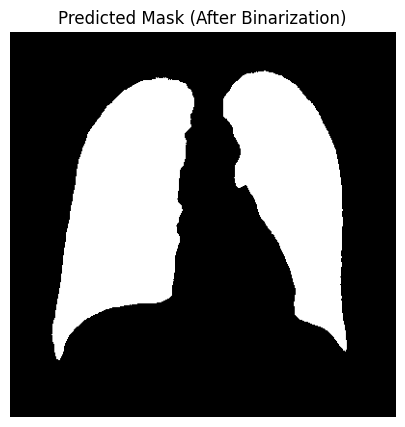

In [ ]:
# Function to load and preprocess the image
def load_and_preprocess_image(image_path, target_size):
    # Load the image, convert to RGB, resize to target size, and normalize
    img = Image.open(image_path).convert("RGB").resize(target_size)
    img_np = np.array(img, dtype=np.float32) / 255.0
    return img_np


# Function to predict and visualize the results
def predict_and_visualize(image_path, target_size, model):
    # Load and preprocess the image
    input_image = load_and_preprocess_image(image_path, target_size)

    # Expand dimensions to fit model input shape
    input_image_expanded = np.expand_dims(input_image, axis=0)

    # Predict the mask
    predicted_mask = model.predict(input_image_expanded)[0]

    # Display the shape and value range of the input image and predicted mask for verification
    print(f"Input image shape: {input_image.shape}")
    print(f"Input image values (min, max): {input_image.min(), input_image.max()}")
    print(f"Predicted mask shape: {predicted_mask.shape}")
    print(f"Predicted mask values (min, max): {predicted_mask.min(), predicted_mask.max()}")


    # Display the predicted mask before binarization
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask (Before Binarization)')
    plt.axis('off')


    # Binarize the predicted mask
    threshold = 0.5
    predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

    # Display the unique values in the binary mask for verification
    print(f"Binary mask values (unique): {np.unique(predicted_mask_binary)}")

    # Display the original image
    plt.subplot(1, 2, 2)
    plt.imshow(input_image)
    plt.title('Original Image')
    plt.axis('off')

    # Display the predicted mask after binarization
    plt.figure(figsize=(10, 5))
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title('Predicted Mask (After Binarization)')
    plt.axis('off')

    plt.show()

# Load the model
#model_path = '/content/drive/MyDrive/רעות לימודים/my_good_augmented_model.h5'
#model = load_model(model_path, custom_objects={'iou': iou, 'iou_thresholded': iou_thresholded})

# Example usage of the function
#The path is above under Paths
target_size = (400, 400)  # Set the target size according to the model
predict_and_visualize(image_path, target_size, model)

In [ ]:
# Evaluate the model on training data
train_loss, train_iou, train_iou_thresholded = model.evaluate(x_train, y_train, verbose=0)

# Print training loss and IoU metrics
print(f'Train Loss: {train_loss:.2f}')
print(f'Train IoU: {train_iou:.2f}')
print(f'Train IoU Thresholded: {train_iou_thresholded:.2f}')

# Evaluate the model on validation data
val_loss, val_iou, val_iou_thresholded = model.evaluate(x_val, y_val, verbose=0)

# Print validation loss and IoU metrics
print(f'Validation Loss: {val_loss:.2f}')
print(f'Validation IoU: {val_iou:.2f}')
print(f'Validation IoU Thresholded: {val_iou_thresholded:.2f}')

Train Loss: 0.06
Train IoU: 0.86
Train IoU Thresholded: 0.92
Validation Loss: 0.08
Validation IoU: 0.83
Validation IoU Thresholded: 0.89


1/1 [==============================] - 0s 327ms/step


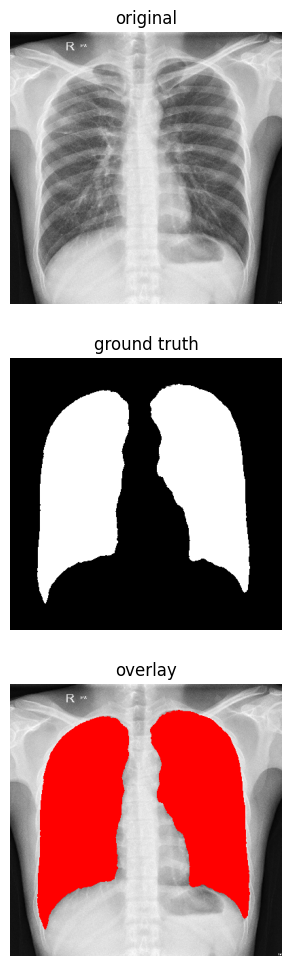

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model

# פונקציה לטעינת התמונה והכנתה
def load_and_preprocess_image(image_path, target_size):
    # טוען את התמונה, ממיר ל-RGB, משנה גודל לגודל המטרה, ומנרמל
    img = Image.open(image_path).convert("RGB").resize(target_size)
    img_np = np.array(img, dtype=np.float32) / 255.0
    return img_np

# פונקציה לחיזוי התמונה והמסכה
def predict_image_and_mask(image_path, target_size, model):
    # טוען ומכין את התמונה
    input_image = load_and_preprocess_image(image_path, target_size)

    # מרחיב את הממדים להתאמה למודל
    input_image_expanded = np.expand_dims(input_image, axis=0)

    # חוזה את המסכה
    predicted_mask = model.predict(input_image_expanded)[0]

    # בינאריזציה של המסכה החזויה
    threshold = 0.5
    predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

    # יוצר את התמונה המודבקת על ידי שילוב של התמונה המקורית והמסכה הבינארית
    overlay = input_image.copy()
    overlay[..., 0][predicted_mask_binary[..., 0] == 1] = 1  # ערוץ אדום
    overlay[..., 1][predicted_mask_binary[..., 0] == 1] = 0  # ערוץ ירוק
    overlay[..., 2][predicted_mask_binary[..., 0] == 1] = 0  # ערוץ כחול

    return input_image, predicted_mask_binary[..., 0], overlay

# פונקציה להצגת התמונות והמסכות
def plot_imgs(org_imgs, mask_imgs, nm_img_to_plot=3, figsize=4):
    plt.figure(figsize=(figsize * nm_img_to_plot, figsize * 3))

    for i in range(nm_img_to_plot):
        plt.subplot(3, nm_img_to_plot, i + 1)
        plt.imshow(org_imgs[i])
        plt.title('original')
        plt.axis('off')

        plt.subplot(3, nm_img_to_plot, i + 1 + nm_img_to_plot)
        plt.imshow(mask_imgs[i], cmap='gray')
        plt.title('ground truth')
        plt.axis('off')

        plt.subplot(3, nm_img_to_plot, i + 1 + 2 * nm_img_to_plot)
        plt.imshow(overlay_imgs[i])
        plt.title('overlay')
        plt.axis('off')

    plt.show()

# טוען את המודל
model_path = '/content/drive/MyDrive/רעות לימודים/my_good_augmented_model.h5'
model = load_model(model_path, custom_objects={'iou': iou, 'iou_thresholded': iou_thresholded})

# דוגמה לשימוש בפונקציה
image_paths = [
    '/content/drive/MyDrive/תמונות מעובדות/test מחולק/CXR_png/CHNCXR_0541_1.png',  # הנתיב לתמונה שהעלית
    # אפשר להוסיף עוד נתיבים לתמונות נוספות
]

target_size = (400, 400)  # קובע את גודל המטרה בהתאם למודל

# הכנת התמונות והמסכות להצגה
org_imgs = []
mask_imgs = []
overlay_imgs = []

for image_path in image_paths:
    org_img, mask_img, overlay_img = predict_image_and_mask(image_path, target_size, model)
    org_imgs.append(org_img)
    mask_imgs.append(mask_img)
    overlay_imgs.append(overlay_img)

# הצגת התמונות והמסכות
plot_imgs(org_imgs=org_imgs, mask_imgs=mask_imgs, nm_img_to_plot=len(image_paths), figsize=4)
